<h2> Import Requirements and Data </h2>

In [1]:
import tensorflow as tf
import keras
import sklearn.metrics
import sklearn.preprocessing
import sklearn.feature_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import gc
import psutil
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
with open('./classifdatafull.pkl', 'rb') as f:
    cfdata = pickle.load(f)
with open('labencdist.pkl', 'rb') as f:
    labencdist = pickle.load(f)
with open('labencsector.pkl', 'rb') as f:
    labencsec = pickle.load(f)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<h2> Design Tensorflow ANN </h2>

<b> STEP 1: Perform Feature Selection

We implement a preliminary feature selection pipeline such that we do not build our Tensorflow Model on the full 129 variable input. The procedure that is implemented includes three stages: 1) Variance Threshold with Robust Scaling, 2) ANOVA f-value tests for continuous and Chi2 tests for categorical variables, and 3) Pearson's Correlation Analysis. Subsequent to the elimination of less informative features, we use a Tensorflow session to start building our model.

In [3]:
trainx, testx, trainy, testy = train_test_split(cfdata.drop(['Div_Paid?'], axis=1), cfdata['Div_Paid?'], 
                                                test_size=0.3, random_state=1)

In [4]:
#Let us first use variance threshold analysis. The amount of acceptable deviation shall be expressed as a 
#percentage of deviation in the response variable
v = sklearn.feature_selection.VarianceThreshold()
v.fit(sklearn.preprocessing.RobustScaler().fit_transform(pd.DataFrame(trainy)))
v.variances_[0]

0.16008194855027022

In [5]:
scr = Pipeline([('scale', 
                 sklearn.preprocessing.RobustScaler()), ('var', sklearn.feature_selection.VarianceThreshold(
    0.8 * v.variances_[0]))])
scr.fit(trainx)

Pipeline(memory=None,
         steps=[('scale',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('var', VarianceThreshold(threshold=0.12806555884021617))],
         verbose=False)

In [6]:
#Remove the identified columns and then proceed to differentiate categorical and continuous variables for further
#feature selection based on ANOVA f-value and chi2 goodness-of-fit
rm = trainx.columns.values[scr['var'].get_support(indices=False)==False]
trainx.drop(rm, axis=1, inplace=True)
cat = set(['DistLast_'+r for r in labencdist.classes_]).union(set(['Sector_'+r for r in labencsec.classes_]))
cat = list(set(trainx.columns.values)&set(cat))
cont = list(set(trainx.columns.values)-set(cat))

In [7]:
#Chi2 tests on categorical data
chivals, pvals = sklearn.feature_selection.chi2(trainx[cat], trainy)
#We eliminate values at chi value of 4, approximately the requirement at a single degree of freedom
rm = np.array(cat)[chivals < 4]
#ANOVA f-value tests
fvals, pvals = sklearn.feature_selection.f_classif(trainx[cont], trainy)
#We eliminate at relative variance lower than 0.5
rm = list(set(rm).union(set(np.array(cont)[fvals < 0.5])))
len(rm)

13

In [8]:
#We eliminate any features with low correlation to the response variable
remain = np.array(list(set(trainx.columns.values)-set(rm)))
corrs = np.vectorize(lambda s: np.corrcoef(trainx[s], trainy)[0,1])(remain)
rm = list(set(rm).union(set(remain[np.vectorize(lambda s: np.abs(s))(corrs) < 0.025])))
print(len(rm))
trainx.drop(rm, axis=1, inplace=True)

21


<b> STEP 2: Prepare Data for Neural Net

In order to ensure that the neural network is able to learn weights and biases effectively, we must scale the data and pickelize the same scaler for use during the actual simulation use. Out of the different approaches to scaling available (including StandardScaler, MinMaxScaler, and RobustScaler), we must choose wisely depending on the distributions of variables at hand. Below is an example visualization of few of the columns. As seen, there do exist outliers, which may reduce range of true values severely in StandardScaler and MinMaxScaler as they are sensitive to extreme values. Hence, we proceed with RobustScaler.

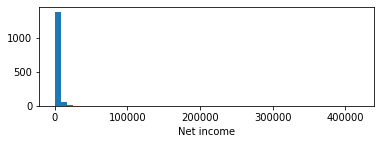

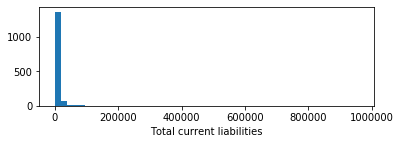

In [9]:
cols = ['Net income', 'Total current liabilities']
for i in range(len(cols)):
    plt.subplot(str(len(cols))+'1'+str(i+1))
    plt.hist(trainx[cols[i]], bins=50)
    plt.xlabel(cols[i])
    plt.show()

In [10]:
rbs = sklearn.preprocessing.RobustScaler()
rbs.fit(trainx)
with open('tfnnscaler.pkl', 'wb') as f:
    pickle.dump(rbs, f)
cols = trainx.columns.values
trainx = pd.DataFrame(rbs.transform(trainx), columns=cols)
testx = pd.DataFrame(rbs.transform(testx[cols]), columns=cols)

In [11]:
#We must also encode our response variable to match the softmax function needs in the neural network
trainy.reset_index(drop=True, inplace=True)
testy.reset_index(drop=True, inplace=True)
trainy = pd.get_dummies(trainy)
testy = pd.get_dummies(testy)

<b> STEP 3: Design Tensorflow NN Architecture

A shalloe, but wide, neural network design was chosen, and hence only one hidden layer has been used, to prevent overfitting and ease interpretability. The design of the artificial neural network shall be as follows:
- 91-node input layer, with all 91 features shortlisted above (Shape: [None, 91])
- 30-node hidden layer, activated by ReLU (Shape: [None, 30])
- 2-node output layer, activated by Softmax (Shape: [None, 2])

In [12]:
X = tf.placeholder(tf.float32, shape=[None, 91])
Yt = tf.placeholder(tf.float32, shape=[None, 2])

In [13]:
#Add the first layer (hidden layer)
W1 = tf.Variable(tf.truncated_normal([91, 30], stddev=0.1))
B1 = tf.Variable(tf.constant(0.1, shape=[30]))
C1 = tf.matmul(X, W1) + B1
L1 = tf.nn.relu(C1)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
W2 = tf.Variable(tf.truncated_normal([30, 2], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, shape=[2]))
C2 = tf.matmul(L1, W2) + B2
Yp = tf.nn.softmax(C2)

In [15]:
loss = tf.nn.l2_loss(Yp-Yt, name='squared_error_cost')
trainer = tf.train.AdamOptimizer(1e-3).minimize(loss)
corrpred = tf.equal(tf.argmax(Yt, 1), tf.argmax(Yp, 1))
acc = tf.reduce_mean(tf.cast(corrpred, tf.float32))

<b> STEP 4: Evaluate Model Performance

In [22]:
sess = tf.Session()
i = tf.global_variables_initializer()
sess.run(i)

In [23]:
for e in range(0,1000):
    _, per, ce = sess.run([trainer, acc, loss], feed_dict={X:trainx, Yt:trainy.values})
    if (e % 100)==0:
        print("Accuracy = "+str(per))

Accuracy = 0.61270493
Accuracy = 0.94808745
Accuracy = 0.9863388
Accuracy = 0.9931694
Accuracy = 0.99590164
Accuracy = 0.99590164
Accuracy = 0.99590164
Accuracy = 0.99590164
Accuracy = 0.99590164
Accuracy = 0.99590164


In [24]:
#Final test-set accuracy
per = sess.run(acc, feed_dict={X:testx, Yt:testy.values})
print("Final Test Set Accuracy = " + str(per))

Final Test Set Accuracy = 0.95382166


In [18]:
sess.close()